In [83]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score 
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import classification_report, mean_squared_error
from matplotlib.ticker import MultipleLocator as mlt
import scipy.interpolate as si
from sklearn.metrics import confusion_matrix as ca

#### 1.a)

In [84]:
import pandas as pd
df = pd.read_csv('data/strongdrink.txt')
X = df[['alco', 'malic', 'tot_phen', 'color_int']]
y = df["cultivar"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=20)

clf = lr(solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

pd.DataFrame({"j=1":np.append(clf.intercept_[0],clf.coef_[0]),
              "j=2":np.append(clf.intercept_[1],clf.coef_[1])},
        index=["beta0","beta1",'beta2','beta3','beta4'])

,j=1,j=2
beta0,-24.027617,22.780733
beta1,1.701734,-1.466297
beta2,-0.265788,-0.332951
beta3,1.224101,0.663556
beta4,0.022507,-0.922682


In [85]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred,  target_names=['j=1', 'j=2', 'j=3']))

              precision    recall  f1-score   support

         j=1       0.87      1.00      0.93        13
         j=2       1.00      0.90      0.95        21
         j=3       1.00      1.00      1.00        10

    accuracy                           0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [86]:
print('While j=2,3 have the lowest error rates, j=3 has the best f1 score, so this model is best at perdicting j3. j3 does not have the most observations. The most accurately predicted category is not the one with the most observations.')
pd.DataFrame([1-0.87, 0, 0],index=['j=1', 'j=2', 'j=3'],columns=['Error Rate'])

While j=2,3 have the lowest error rates, j=3 has the best f1 score, so this model is best at perdicting j3. j3 does not have the most observations. The most accurately predicted category is not the one with the most observations.


,Error Rate
j=1,0.13
j=2,0.00
j=3,0.00


In [87]:
print('MSE:', mean_squared_error(y_test, y_pred))

MSE: 0.045454545454545456


#### 1.b)

In [88]:
Xvars = X.values
yvars = y.values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
MSE_vec = np.zeros(N_loo)
ypred = np.zeros(N_loo)
ytest = np.zeros(N_loo)

for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    ytest[test_index] = y_test
    LogReg = lr(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    ypred[test_index] = y_pred
    if y_test == y_pred: MSE_vec[test_index] = 0
    else:MSE_vec[test_index] = 1
    print('MSE for test set', test_index, ' is', MSE_vec[test_index])

MSE for test set [0]  is [0.]
MSE for test set [1]  is [0.]
MSE for test set [2]  is [0.]
MSE for test set [3]  is [0.]
MSE for test set [4]  is [0.]
MSE for test set [5]  is [0.]
MSE for test set [6]  is [0.]
MSE for test set [7]  is [0.]
MSE for test set [8]  is [0.]
MSE for test set [9]  is [0.]
MSE for test set [10]  is [0.]
MSE for test set [11]  is [0.]
MSE for test set [12]  is [0.]
MSE for test set [13]  is [0.]
MSE for test set [14]  is [0.]
MSE for test set [15]  is [0.]
MSE for test set [16]  is [0.]
MSE for test set [17]  is [0.]
MSE for test set [18]  is [0.]
MSE for test set [19]  is [0.]
MSE for test set [20]  is [0.]
MSE for test set [21]  is [0.]
MSE for test set [22]  is [0.]
MSE for test set [23]  is [1.]
MSE for test set [24]  is [0.]
MSE for test set [25]  is [1.]
MSE for test set [26]  is [0.]
MSE for test set [27]  is [0.]
MSE for test set [28]  is [0.]
MSE for test set [29]  is [0.]
MSE for test set [30]  is [0.]
MSE for test set [31]  is [0.]
MSE for test set [

In [89]:
print('test estimate MSE loocv:',MSE_vec.mean(),
      '\nMSE std:', MSE_vec.std())
print(classification_report(yvars, ypred))
pd.DataFrame([1-0.9, 1-0.91, 1-0.96],index=['j=1', 'j=2', 'j=3'],columns=['Error Rate'])

test estimate MSE loocv: 0.07954545454545454 
MSE std: 0.2705882022679695
              precision    recall  f1-score   support

           1       0.90      0.93      0.92        59
           2       0.91      0.90      0.91        71
           3       0.96      0.93      0.95        46

    accuracy                           0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



,Error Rate
j=1,0.10
j=2,0.09
j=3,0.04


All three error rates have increased comparing to part a.
#### 1.c)

In [90]:
k = 4
kf = KFold(k, random_state=10, shuffle=True)
kf.get_n_splits(Xvars)
MSE_vec_kf = np.zeros(k)
y_pred = np.zeros(N_loo)
k_ind = int(0)
for train_index, test_index in kf.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvars[train_index], yvars[test_index]
    LogReg = lr(solver='newton-cg',multi_class='multinomial').fit(X_train, y_train)
    y_pred[test_index] = LogReg.predict(X_test)
    err= y_pred[test_index] != y_test  
    MSE_vec_kf[k_ind]=np.mean(err)
    print('MSE for test set', k_ind, ':', MSE_vec_kf[k_ind])
    k_ind += 1
print('test estimate MSE k-fold(k=4) =', MSE_vec_kf.mean())
print(classification_report(yvars, y_pred))
pd.DataFrame([1-0.87, 1-0.91, 1-0.96],index=['j=1', 'j=2', 'j=3'],columns=['Error Rate'])

MSE for test set 0 : 0.1590909090909091
MSE for test set 1 : 0.11363636363636363
MSE for test set 2 : 0.045454545454545456
MSE for test set 3 : 0.045454545454545456
test estimate MSE k-fold(k=4) = 0.09090909090909091
              precision    recall  f1-score   support

           1       0.87      0.93      0.90        59
           2       0.91      0.87      0.89        71
           3       0.96      0.93      0.95        46

    accuracy                           0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176



,Error Rate
j=1,0.13
j=2,0.09
j=3,0.04


Error rates for j = 2,3 are the same, but j=1 has increased.
#### 2.a)

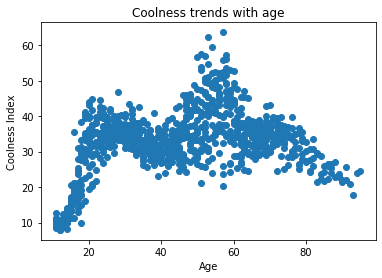

In [91]:
df = pd.read_csv('data/CoolIndex.txt', names = ['Age', 'Cool'])
plt.scatter(df.Age,df.Cool,)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Coolness trends with age')
plt.show()

#### 2.b)

In [92]:
df["G1"]=np.where((df.Age>=11) & (df.Age<22),1,0)
df["G2"]=np.where((df.Age>=22) & (df.Age<40),1,0)
df["G3"]=np.where((df.Age>=40) & (df.Age<59),1,0)
df["G4"]=np.where((df.Age>=59) & (df.Age<77),1,0)
df["G5"]=np.where((df.Age>=77) & (df.Age<=95),1,0)
X=df[["G1","G2","G3","G4","G5"]]
res=sm.OLS(df.Cool,X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Cool   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Wed, 26 Feb 2020   Prob (F-statistic):          3.73e-114
Time:                        10:04:05   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1            20.1025      0.562     35.746      0.000      18.999      21.206
G2            34.4758      0.431     80.006      0.000      33.630      35.321
G3            37.6351      0.424     88.814      0.000      36.804      38.467
G4            35.2254      0.485     72.560      0.000      34.273      36.178
G5            27.2964      0.936     29.175      0.000      25.460      29.132
==============================================================================
Omnibus:                       80.102   Durbin-Watson:                   1.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.718
Skew:                           0.714   Prob(JB):                     8.17e-23
Kurtosis:                       3.719   Cond. No.                         2.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

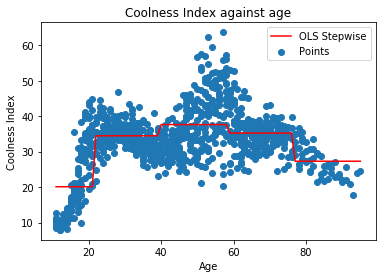

Predicted coolness of a 73-year old: [35.22540004]


In [93]:
plt.scatter(df.Age,df.Cool, label="Points")
plt.plot(df.Age,res.predict(),"r",label = "OLS Stepwise")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()
print('Predicted coolness of a 73-year old:',str(res.predict([0,0,0,1,0])))


#### 2.c)

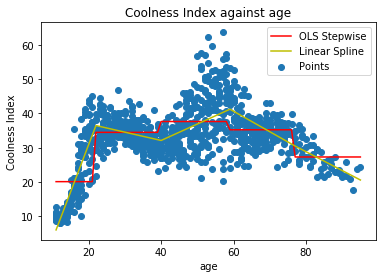

Predicted coolness of a 73-year old: 32.86784862349653


In [94]:
df2=df.groupby('Age').mean()
df2['Age']=df2.index
knots=[22,40,59,77]
ls=si.LSQUnivariateSpline(np.array(df2.Age), np.array(df2.Cool), t=knots, k=1)
plt.scatter(df.Age,df.Cool,label="Points")
plt.plot(df.Age,res.predict(),"r",label = "OLS Stepwise")
plt.plot(df2.Age,ls(df2.Age),"y",label = "Linear Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()
print('Predicted coolness of a 73-year old:',str(ls(73)))


#### 2.d)

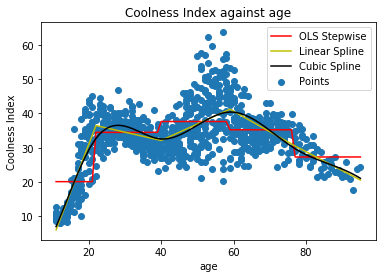

Predicted coolness of a 73-year old: 32.642301066279764


In [95]:
ls2=si.LSQUnivariateSpline(np.array(df2.Age), np.array(df2.Cool), t=knots, k=3)
plt.scatter(df.Age,df.Cool,label="Points")
plt.plot(df.Age,res.predict(),"r",label = "OLS Stepwise")
plt.plot(df2.Age,ls(df2.Age),"y",label = "Linear Spline")
plt.plot(df2.Age,ls2(df2.Age),'k',label = "Cubic Spline")
plt.legend()
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Coolness Index against age")
plt.show()
print('Predicted coolness of a 73-year old:',str(ls2(73)))
